<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_AMZN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [313]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [314]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-s8hlfbt3
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-s8hlfbt3
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0dfd9739e4bdcce166dc6326afcde41af9a5f8641_-cp36-none-any.whl size=119874 sha256=5798488ffe355a9b7af6e826485d0798a63a83a9dd1e526996fcb99d163da912
  Stored in directory: /tmp/pip-ephem-wheel-cache-zd6iqcmn/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [315]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [316]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [426]:
import pandas as pd 
df=pd.read_csv('gdrive/My Drive/SS_AITrader/AMZN/df_AMZN_20drtn_features.csv')

In [396]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,41.865788,43.034542,40.031563,31.981017,-64.824174,-67.741989,-68.325831,-91.389927,50.041713,42.669514,44.472969,41.488342,-1.955907,2.148944,-1.288939,-1.886123,-3.330998,-0.465781,-0.571661,-0.536914,-0.255136,-0.991226,-0.991226,-0.991226,-0.991226,47.307086,-9.094041,-44.116469,-71.200896,-125.758917,-146.229221,0.104477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.277218,0.108300,0.235336,-0.082116,0.307083,0.004476,27.549999,2.949999,4.019999,-4.363137e+06,-4.363137e+06,-4.363137e+06,-4.363137e+06,-0.165406,-0.203908,-0.183034,-0.219558,-0.144259,2.257,0.044,0.397,-0.480003,-0.720001,1.0
1,2008-03-07,47.826094,40.235002,45.718145,35.106898,-49.748738,-52.153070,-54.751112,-87.699876,60.920745,48.041562,50.565685,41.316390,1.088143,1.014863,2.463236,0.686418,-0.889047,-0.426407,-0.551505,-0.531042,-0.261552,-0.921842,-0.921842,-0.921842,-0.921842,31.930764,-7.650264,-34.213926,-73.315369,-116.064252,-135.067341,0.733335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273121,0.077530,0.234483,-0.081353,0.297030,-0.009625,27.490000,-0.059999,0.949999,4.851032e+06,4.851032e+06,4.851032e+06,4.851032e+06,-0.109093,-0.133604,-0.129300,-0.225351,-0.148474,2.141,-0.116,0.392,0.029999,-0.680000,1.0
2,2008-03-10,54.566730,45.782790,49.578465,32.158353,-40.703591,-43.540699,-45.871593,-85.485873,59.287152,53.149360,49.093121,41.109444,0.645850,-0.248939,3.927379,0.754307,-1.785715,-0.381584,-0.527982,-0.522776,-0.267444,-0.842617,-0.842617,-0.842617,-0.842617,73.901362,41.455439,25.070256,-34.497501,-107.850424,-125.120477,0.588234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.273487,0.077594,0.228361,-0.004517,0.298416,-0.007056,29.379999,1.889999,3.099998,7.564489e+06,7.564489e+06,7.564489e+06,7.564489e+06,-0.093010,-0.117782,-0.110117,-0.231302,-0.069880,2.138,-0.003,0.239,-0.040001,-0.709999,1.0
3,2008-03-11,64.447161,57.396060,54.889495,36.822324,-2.429129,-2.429129,-2.429129,-70.356702,58.925179,59.115585,56.278644,42.996759,4.385032,6.202398,6.125410,3.171253,3.792987,-0.309431,-0.494112,-0.509082,-0.272398,-0.672824,-0.672824,-0.672824,-0.672824,166.666667,181.862307,197.810885,132.814985,-97.027289,-112.534689,0.937501,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.339431,0.102415,0.273435,0.020421,0.321756,0.013063,26.360001,-3.019999,0.840000,4.552673e+07,4.552673e+07,4.552673e+07,4.552673e+07,-0.020261,-0.018940,-0.053242,-0.205641,0.368072,2.156,0.018,0.172,0.290001,-0.380005,0.0
4,2008-03-12,51.615506,53.056046,52.325655,36.247180,-32.824464,-32.824464,-32.824464,-78.351802,50.158480,59.751385,51.747502,41.482053,-2.219951,2.726940,1.813650,1.309267,1.023285,-0.240111,-0.457893,-0.493021,-0.276705,-0.583980,-0.583980,-0.583980,-0.583980,76.200064,136.816968,147.727261,121.145361,-88.768984,-102.529325,0.094735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361883,0.102073,0.286302,0.051604,0.321833,0.008435,27.219999,0.859999,2.619999,1.388579e+07,1.388579e+07,1.388579e+07,1.388579e+07,-0.051715,-0.113685,-0.083244,-0.221880,-0.230370,2.043,-0.113,-0.170,-0.879997,-1.080002,1.0


In [427]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [428]:
from_date='2010-01-01'
to_date='2020-01-01'

In [429]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [400]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,71.393632,63.202470,61.326716,64.766705,-47.787727,-27.979318,-24.000041,-16.363668,77.823898,72.822326,70.628810,68.679806,0.032305,0.000000,-0.673728,1.976280,3.268844,0.223252,0.218912,0.244169,0.281295,0.449064,0.449064,0.449064,0.449064,-23.088105,-0.566587,49.138394,83.156463,47.209416,53.236178,0.695650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154032,-0.013830,0.163112,0.014023,0.156250,-0.005745,19.350000,-0.690001,-0.580000,1.368606e+06,1.368606e+06,1.368606e+06,1.368606e+06,0.156515,0.097234,0.088590,0.186999,0.295256,3.695,-0.091,-0.092,0.090004,-0.009995,0.0
446,2010-01-06,57.390212,60.506715,57.738107,61.947740,-71.568550,-37.823804,-32.444424,-24.579115,62.470388,64.633992,68.818138,67.816165,-0.613691,0.951447,-1.975148,0.819135,3.289693,0.209822,0.214629,0.240274,0.279987,0.418543,0.418543,0.418543,0.418543,-37.521595,-62.994555,24.392363,62.019997,45.740044,51.638385,0.446429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157851,-0.009022,0.162983,0.013721,0.157627,0.003620,19.160000,-0.190001,-0.850000,-2.772454e+06,-2.772454e+06,-2.772454e+06,-2.772454e+06,0.172051,0.050180,0.099441,0.171127,0.169505,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,48.118816,53.617997,56.211874,59.727456,-80.152646,-54.404097,-46.666633,-38.181790,50.221809,64.456586,67.669040,64.911152,-1.039973,-1.615509,-1.647281,-1.200516,2.975993,0.187078,0.206542,0.234640,0.278338,0.364333,0.364333,0.364333,0.364333,-129.128895,-177.378583,-51.318022,12.410045,43.908787,49.560908,0.509804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.158332,-0.028914,0.165536,0.019023,0.156046,-0.003518,19.059999,-0.100000,-0.900000,-7.241332e+06,-7.241332e+06,-7.241332e+06,-7.241332e+06,0.124730,0.063452,0.096636,0.141907,-0.131014,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,47.472254,57.285873,60.666944,58.712005,-64.122175,-43.523317,-43.523317,-30.545460,53.097260,64.243148,67.969036,64.685894,0.689652,-0.968990,0.590552,-0.840880,3.197579,0.164305,0.197239,0.228285,0.276467,0.334461,0.334461,0.334461,0.334461,-53.080531,-92.403785,-29.156306,29.391119,41.622846,47.046687,0.656251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162192,-0.047268,0.166269,0.010812,0.156671,-0.004871,18.129999,-0.930000,-3.550001,-1.243753e+06,-1.243753e+06,-1.243753e+06,-1.243753e+06,0.102407,0.148970,0.081095,0.157445,0.012613,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,38.495565,51.475170,54.976226,56.256261,-89.130456,-72.352882,-63.730536,-44.727256,43.835861,61.717334,61.067142,61.274701,-1.272014,-1.624959,-2.197093,-2.354837,1.339135,0.134814,0.184597,0.220218,0.274215,0.276135,0.276135,0.276135,0.276135,-89.705084,-119.552998,-110.162829,-3.647167,39.168195,44.195691,0.234375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171202,-0.022552,0.173121,0.009665,0.160499,0.001239,17.549999,-0.580000,-2.490002,-9.767265e+06,-9.767265e+06,-9.767265e+06,-9.767265e+06,-0.017613,0.143953,0.016837,0.143485,0.342933,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [401]:
df.tail()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
2890,2019-12-20,84.148053,67.616351,72.208864,76.742053,-13.235311,-9.121628,-9.121628,-5.598763,73.947854,67.246908,71.132596,67.375933,1.091771,1.758356,1.863719,3.729821,5.305063,0.218965,0.212944,0.208794,0.139993,2.424918,2.424918,2.424918,2.424918,166.666667,137.466082,146.970490,207.332184,50.249866,57.284793,0.509093,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.096289,-0.017575,0.104966,0.001749,0.114492,-0.020492,12.51,0.010000,-0.120000,3.878017e+07,3.878017e+07,3.878017e+07,3.878017e+07,0.155028,0.207635,0.224972,0.196086,1.142622,0.389,0.014,0.093,0.290001,0.540001,1.0
2891,2019-12-23,80.694159,71.959191,72.644194,74.921508,-13.235311,-9.121628,-9.121628,-6.818188,74.123193,74.164938,71.306969,67.161624,0.000000,1.969300,1.208773,3.997095,5.227627,0.233038,0.217974,0.211414,0.142390,2.524014,2.524014,2.524014,2.524014,88.770057,123.907912,126.704348,181.211061,51.462775,58.693955,0.164707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092400,0.009248,0.105172,0.008513,0.114516,-0.011702,12.61,0.099999,0.469999,2.585345e+07,2.585345e+07,2.585345e+07,2.585345e+07,0.127798,0.202825,0.196091,0.166893,-0.668679,0.415,0.026,0.048,-0.029999,0.610001,1.0
2892,2019-12-27,87.696721,85.804732,70.938052,75.979955,-8.779706,-6.357720,-4.573612,-3.558482,75.319313,77.263772,67.935529,67.319483,0.182775,0.984692,2.087213,3.732708,4.359243,0.268523,0.234935,0.221122,0.149915,2.759320,2.759320,2.759320,2.759320,123.163816,109.800638,123.056812,145.845762,54.107420,61.677190,0.556394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.087829,-0.011186,0.102497,0.001623,0.093192,-0.027184,13.43,0.780001,0.850000,1.356284e+07,1.356284e+07,1.356284e+07,1.356284e+07,0.072509,0.168700,0.155807,0.211714,0.268047,0.356,-0.014,-0.019,-0.669998,-0.490005,1.0
2893,2019-12-30,71.812839,76.782163,64.664950,71.099898,-33.793201,-21.258204,-15.193840,-11.821511,67.342260,72.252048,67.156009,67.837210,-0.861859,0.133430,0.114346,1.980196,4.102253,0.271431,0.238724,0.223878,0.152403,2.680318,2.680318,2.680318,2.680318,-29.625731,50.084015,78.824541,106.294180,53.560325,61.086342,0.375545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102531,0.006242,0.105459,0.000493,0.093226,-0.021266,14.82,1.389999,2.320000,1.576065e+06,1.576065e+06,1.576065e+06,1.576065e+06,-0.010940,0.113913,0.167101,0.227054,-0.112118,0.405,0.049,0.016,-0.180000,-0.680000,1.0
2894,2019-12-31,69.164817,74.183784,68.797849,74.282321,-31.896640,-20.065139,-14.341122,-11.315018,58.244782,66.824025,68.411468,68.871830,0.069802,-0.611332,0.184228,1.395228,5.449678,0.268132,0.240426,0.225771,0.154781,2.596653,2.596653,2.596653,2.596653,-79.728686,20.196461,55.187546,86.915493,53.661036,60.666869,0.946964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.099504,0.007104,0.091607,-0.013565,0.093321,-0.021195,13.78,-1.040000,1.270000,1.724259e+06,1.724259e+06,1.724259e+06,1.724259e+06,0.028443,0.178597,0.228903,0.250066,0.123621,0.414,0.009,-0.001,-0.349998,-1.320000,1.0


In [430]:
df.drop(['timestamp'], inplace=True, axis=1)

In [431]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [432]:
train_dataset.head()

,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
1856,52.130767,55.536149,61.426514,51.993594,-4.024511,-10.290205,-10.290205,-6.175374,40.210793,54.971420,60.997754,55.742919,2.091864,6.210314,7.860174,-0.858882,8.953906,0.032776,0.093353,0.131321,0.254748,3.448769,3.448769,3.448769,3.448769,131.523936,99.788270,88.214520,118.733912,26.153617,19.544187,0.774976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.362150,0.078771,0.304741,-0.000476,0.386407,0.017306,19.540001,-1.400000,-8.089998,2.735479e+07,2.735479e+07,2.735479e+07,2.735479e+07,0.238939,0.268500,0.234727,0.059812,-0.262386,2.048,6.700003e-02,-0.034,0.279999,0.080002,1.0
2747,32.281095,39.171430,46.974678,56.630236,-65.081072,-71.900429,-71.900429,-48.866139,37.851437,33.720316,37.704136,52.894185,-0.077998,-2.623753,0.945592,-3.304528,-3.443759,-0.049239,0.122073,0.205722,0.193800,4.219008,4.219008,4.219008,4.219008,-40.629466,-30.139842,-64.093716,-75.330819,20.695216,27.658733,0.349092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.263179,-0.011215,0.252039,0.010340,0.200657,-0.007615,14.950000,-1.360000,-3.110000,-2.152336e+07,-2.152336e+07,-2.152336e+07,-2.152336e+07,0.063918,0.105319,0.070089,0.134703,0.054473,0.096,2.384186e-07,0.030,0.129997,0.529999,1.0
898,40.629029,48.434294,48.238098,50.520570,-58.545801,-58.545801,-58.545801,-58.545801,33.625692,45.764587,48.491302,50.822547,5.097209,-4.327531,-7.436746,-11.912772,0.504098,-0.079073,0.160707,0.224198,0.188416,-1.399414,-1.399414,-1.399414,-1.399414,-19.402789,-73.054593,-115.079372,-89.808069,33.030079,48.833966,0.914626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.823621,0.412826,0.635847,0.243025,0.530332,0.138768,24.530001,-0.929998,-6.789999,-6.228630e+07,-6.228630e+07,-6.228630e+07,-6.228630e+07,-0.134517,-0.037236,0.037170,0.094384,-0.082966,2.296,-8.899999e-02,0.108,0.219994,-1.210007,0.0
765,47.951234,65.288726,72.980917,52.018669,-23.561222,-34.108574,-21.042603,-15.895982,36.469236,52.934143,62.164172,46.108803,2.824062,2.144326,0.866752,0.607354,11.220655,0.276436,0.210519,0.091353,0.013329,2.213509,2.213509,2.213509,2.213509,125.908043,64.199585,57.748917,69.186319,73.621371,61.038772,0.668621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212937,0.028814,0.249110,-0.007583,0.240458,-0.010071,15.070000,-0.760000,-1.850000,4.971393e+06,4.971393e+06,4.971393e+06,4.971393e+06,0.278608,0.180064,0.158621,0.031486,0.537226,3.345,4.400015e-02,-0.071,-0.659996,-0.610001,1.0
1100,73.205090,64.262596,57.825859,59.975240,-23.475422,-21.696981,-19.002137,-10.260825,85.234688,70.989538,58.010595,57.293045,-0.740623,0.337306,1.485331,4.938907,3.316533,0.307418,0.259853,0.215752,0.168023,4.536592,4.536592,4.536592,4.536592,87.237604,120.012632,114.250814,137.973550,66.205061,66.860256,0.182649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178167,0.026430,0.166719,-0.169377,0.284044,-0.014740,16.350000,1.170000,2.330000,2.445581e+06,2.445581e+06,2.445581e+06,2.445581e+06,0.054391,0.004158,-0.063764,0.118558,-0.207932,1.554,-3.399992e-02,-0.175,0.070007,-0.799995,1.0


In [433]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [434]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [435]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [436]:
get_sample_weights(train_labels)

real class weights are [1.43484627 0.76742365] [0 1]
value_counts (array([0, 1]), array([ 683, 1277]))


1856    0.767424
2747    0.767424
898     1.434846
765     0.767424
1100    0.767424
          ...   
2051    0.767424
1301    0.767424
2192    0.767424
1640    1.434846
2882    0.767424
Name: labels, Length: 1960, dtype: float64

In [437]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.43484627 0.76742365] [0 1]
value_counts (array([0, 1]), array([ 683, 1277]))


In [438]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [439]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [440]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_10',
 'rsi_40',
 'mfi_20',
 'mfi_40',
 'roc_20',
 'trix_10',
 'trix_15',
 'trix_20',
 'trix_40',
 'kst_20',
 'kst_40',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_40',
 'realised_vol_change_5d_40',
 'vix_level',
 'cmf_15',
 'cmf_20',
 'cmf_40',
 'curve')

In [441]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_20',
 'wr_40',
 'mfi_40',
 'trix_10',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'kst_40',
 'bb_h20',
 'realised_vol_10',
 'realised_vol_20',
 'realised_vol_change_5d_20',
 'realised_vol_40',
 'cmf_10',
 'cmf_15',
 'cmf_40',
 'curve')

In [442]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_20,wr_40,mfi_40,trix_10,trix_20,trix_40,macd10,macd15,macd20,macd40,kst_40,bb_h20,realised_vol_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,cmf_10,cmf_15,cmf_40,curve
445,-0.958323,-0.370525,0.196864,0.140207,1.195750,3.058842,-0.183037,-0.183037,-0.183037,-0.183037,0.137222,-0.296033,0.172398,0.070093,-0.581015,0.039671,-0.489147,-0.929726,-0.187639,2.013397
448,-0.426212,-0.814192,-0.410906,-0.167122,0.923867,2.891877,-0.245629,-0.245629,-0.245629,-0.245629,-0.007590,-0.296033,-0.281296,0.126922,-0.061837,-0.099106,-1.240513,-0.479736,-0.555604,2.093196
452,-0.754320,-1.863536,-1.135965,-0.724882,0.492154,2.614101,-0.342741,-0.342741,-0.342741,-0.342741,-0.391337,-0.296033,-0.021707,0.113603,0.084725,0.012252,-0.794437,-0.902946,-0.660178,2.006838
469,-1.753582,-1.648270,-1.496346,-1.841357,-1.318066,1.005407,-0.533530,-0.533530,-0.533530,-0.533530,-1.735715,-0.296033,0.768886,0.306452,-0.175157,0.100505,-0.006271,-0.623719,-1.317723,1.836308
470,-1.612585,-1.728540,-1.470132,-1.822711,-1.392359,0.904989,-0.530442,-0.530442,-0.530442,-0.530442,-1.747270,-0.296033,0.534133,0.249023,-0.293700,0.097466,-0.286608,-0.470070,-1.252900,1.902990


In [443]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [444]:
criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [445]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.40563306, 0.5943669 ],
       [0.44028726, 0.5597127 ],
       [0.28485635, 0.7151437 ],
       [0.3855838 , 0.6144162 ],
       [0.42916113, 0.5708388 ],
       [0.32179844, 0.6782015 ],
       [0.35280895, 0.64719105],
       [0.37794662, 0.6220534 ],
       [0.40515536, 0.5948446 ],
       [0.38215438, 0.61784565]], dtype=float32)

In [446]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
73/79 [==========================>...] - ETA: 0s - loss: 0.7268 - accuracy: 0.5082
Epoch: 0, accuracy:0.5089,  loss:0.7258,  val_accuracy:0.3571,  val_loss:0.6852,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7258 - accuracy: 0.5089 - val_loss: 0.6852 - val_accuracy: 0.3571
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7094 - accuracy: 0.4923 - val_loss: 0.6766 - val_accuracy: 0.5587
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7068 - accuracy: 0.4994 - val_loss: 0.6782 - val_accuracy: 0.4796
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7009 - accuracy: 0.4904 - val_loss: 0.6765 - val_accuracy: 0.4898
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6906 - accuracy: 0.5338 - val_loss: 0.6695 - val_accuracy: 0.6837
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6858 - accuracy: 0.5695 - val_loss: 0.6634 - val_accur

In [304]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.346867,0.855230,0.416171,0.793367,195
196,0.329919,0.860332,0.418169,0.775510,196
197,0.363506,0.843112,0.430488,0.778061,197
198,0.342190,0.852679,0.431234,0.790816,198
199,0.347882,0.845026,0.432464,0.775510,199


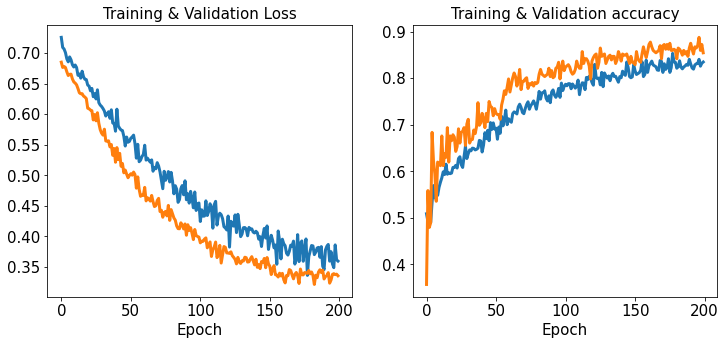

In [447]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [291]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394116 sha256=a0f86cafc8d2d87c3226574d6e57aa1e7d4381fcc214924ffcc0284d33e88ac0
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [448]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [449]:
shap_values  = explainer.shap_values(np.array(X_test_new))

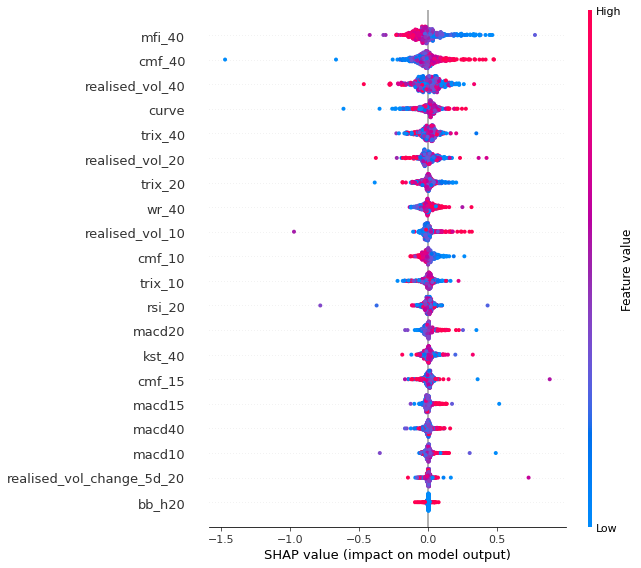

In [450]:
shap.summary_plot(shap_values[1], X_test_new)

In [451]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [452]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


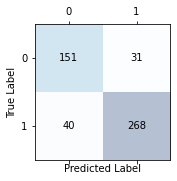

In [453]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [454]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.896
Recall: 0.870
F1: 0.883
